Imports

In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from mmdet.datasets.pipelines import Compose
from mmcv.parallel import collate, scatter
import matplotlib.pyplot as plt
import cv2
import numpy as np
from mmdet.core.visualization import imshow_det_bboxes

Initialize Model

In [2]:
config_file = '../configs/mapillary/mapillary_frcnn_full_fpn_coco copy.py'
checkpoint_file = '../work_dirs/mapillary_frcnn_full_fpn_coco/epoch_36.pth'

In [3]:
model = init_detector(config_file, checkpoint_file, device='cuda')

/workspace/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


Use load_from_local loader


In [4]:
model.CLASSES

['other-sign',
 'regulatory--stop--g1',
 'regulatory--keep-left--g1',
 'complementary--chevron-right--g5',
 'information--parking--g1',
 'warning--bicycles-crossing--g2',
 'warning--curve-left--g2',
 'regulatory--no-entry--g1',
 'regulatory--go-straight--g1',
 'regulatory--yield--g1',
 'warning--trail-crossing--g2',
 'complementary--keep-left--g1',
 'regulatory--no-parking--g5',
 'regulatory--no-parking--g1',
 'information--parking--g3',
 'complementary--distance--g3',
 'regulatory--maximum-speed-limit-50--g1',
 'warning--road-widens-right--g1',
 'regulatory--no-overtaking--g1',
 'warning--roadworks--g1',
 'warning--other-danger--g1',
 'warning--road-narrows-left--g1',
 'warning--slippery-road-surface--g2',
 'warning--roadworks--g2',
 'warning--roundabout--g25',
 'complementary--chevron-left--g4',
 'warning--children--g2',
 'regulatory--no-overtaking--g5',
 'warning--uneven-roads-ahead--g1',
 'regulatory--turn-right-ahead--g1',
 'regulatory--road-closed-to-vehicles--g3',
 'complementar

Input Configuration

In [6]:
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=False)
data_pipeline = [
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            # dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'], meta_keys=('ori_shape','img_shape', 'pad_shape', 'scale_factor', 'img_norm_cfg')),
        ])
]
data_pipeline = Compose(data_pipeline)

In [34]:
from mmcv.ops.nms import batched_nms
import torch
def post_processing(results, score_thr = 0.3, nms_cfg = dict(type='nms', iou_threshold=0.2)):
    bboxes = np.vstack(results[0])
    labels = [
            np.full(bbox.shape[0], i, dtype=np.int32)
            for i, bbox in enumerate(results[0])
        ]
    labels = torch.Tensor(np.concatenate(labels))
    boxes, scores = torch.Tensor(bboxes[:,:4]),torch.Tensor(bboxes[:,4])
    #print("boxes: ", boxes)
    #print("scores: ", scores)
    #print("labels: ", labels)
    valid_mask = scores > score_thr
    inds = valid_mask.nonzero(as_tuple=False).squeeze(1)
    #print('inds: ', inds)
    bboxes, scores, labels = boxes[inds], scores[inds], labels[inds]
    #print("boxes: ", boxes)
    #print("scores: ", scores)
    #print("labels: ", labels)
    bboxes = torch.cat([bboxes, bboxes.new_zeros(1, 4)], dim=0)
    scores = torch.cat([scores, scores.new_zeros(1)], dim=0)
    labels = torch.cat([labels, labels.new_zeros(1)], dim=0)
    #dets, keep = batched_nms(bboxes, scores, labels, nms_cfg)
    keep = torch.ops.torchvision.nms(bboxes, scores, 0.3)
    labels = labels[keep]
    bboxes = bboxes[keep]
    scores = scores[keep].unsqueeze(1)
    #print( keep, scores)
    return torch.cat([bboxes, scores], dim = 1).numpy(), labels.to(torch.int).numpy()

In [30]:
boxes, labels = post_processing(results)

Load Image (Replace with ROS Image)

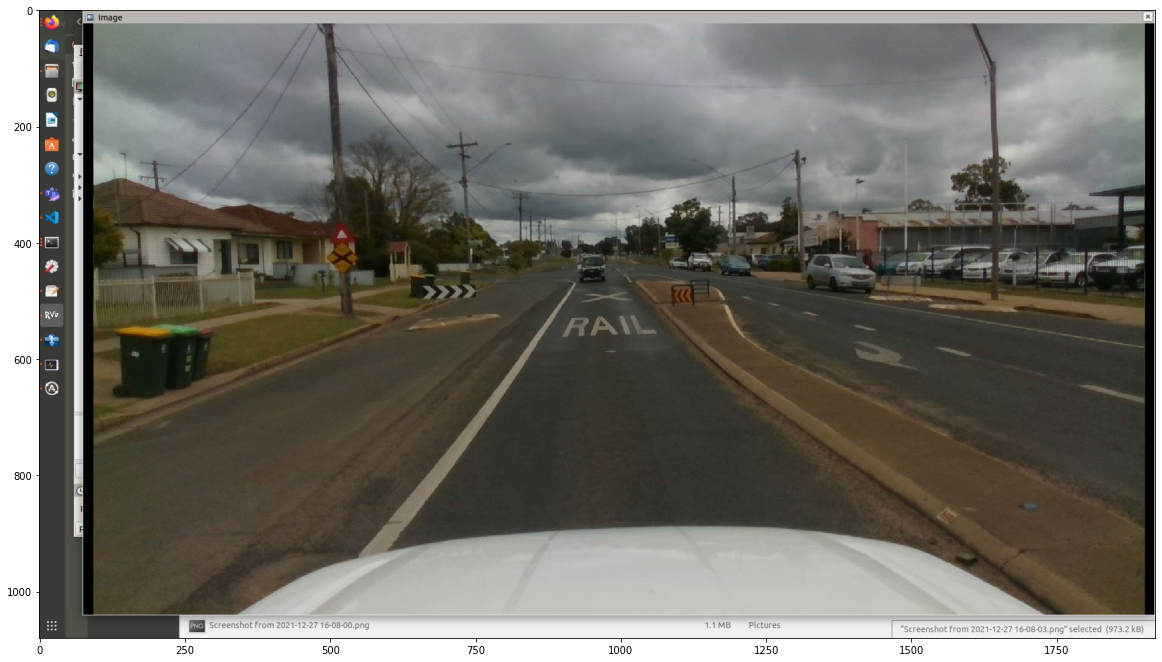

In [94]:
img = '../data/mapillary_sample/test/Screenshot from 2021-12-27 16-13-37.png'
image = cv2.imread(img)[:,:,::-1]
plt.figure(figsize=(20,20))
plt.imshow(image)

Image Preprocessing 

In [95]:
data = dict(img=image, ori_shape=image.shape) # RGB Format
data = data_pipeline(data)
data = collate([data], samples_per_gpu=1)
data = scatter(data, ['cuda:0'])[0]

Inference

In [96]:
results = model(return_loss=False, rescale=True, **data)
boxes, labels = post_processing(results)
viz_image = imshow_det_bboxes(
            image,
            boxes,
            labels,
            class_names=model.CLASSES,
            score_thr=0.1,
            bbox_color=(72, 101, 241),
            text_color=(72, 101, 241),
            thickness=2,
            font_size=20,
            win_name='',
            show=False,
            wait_time=0,
            out_file=None)

In [97]:
boxes, labels

(array([[4.9480780e+02, 3.9914267e+02, 5.4858466e+02, 4.5471002e+02,
         9.7406137e-01],
        [5.0265552e+02, 3.6574969e+02, 5.4075024e+02, 3.9699216e+02,
         9.7228277e-01],
        [6.4982819e+02, 4.7213834e+02, 7.5341998e+02, 4.9686313e+02,
         9.6418232e-01],
        [5.9634830e+01, 8.3522229e+02, 7.7140930e+01, 8.8525385e+02,
         5.0256914e-01],
        [6.0324291e+01, 8.8064746e+02, 7.6187363e+01, 9.0551843e+02,
         4.7455367e-01],
        [5.9101757e+01, 5.1009293e+01, 7.5771088e+01, 1.3869366e+02,
         3.1323668e-01],
        [1.0724067e+03, 3.8815961e+02, 1.0996084e+03, 4.0007361e+02,
         3.1091547e-01],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00]], dtype=float32),
 array([236,   0,  81,   0,   0,   0,   0,   0], dtype=int32))

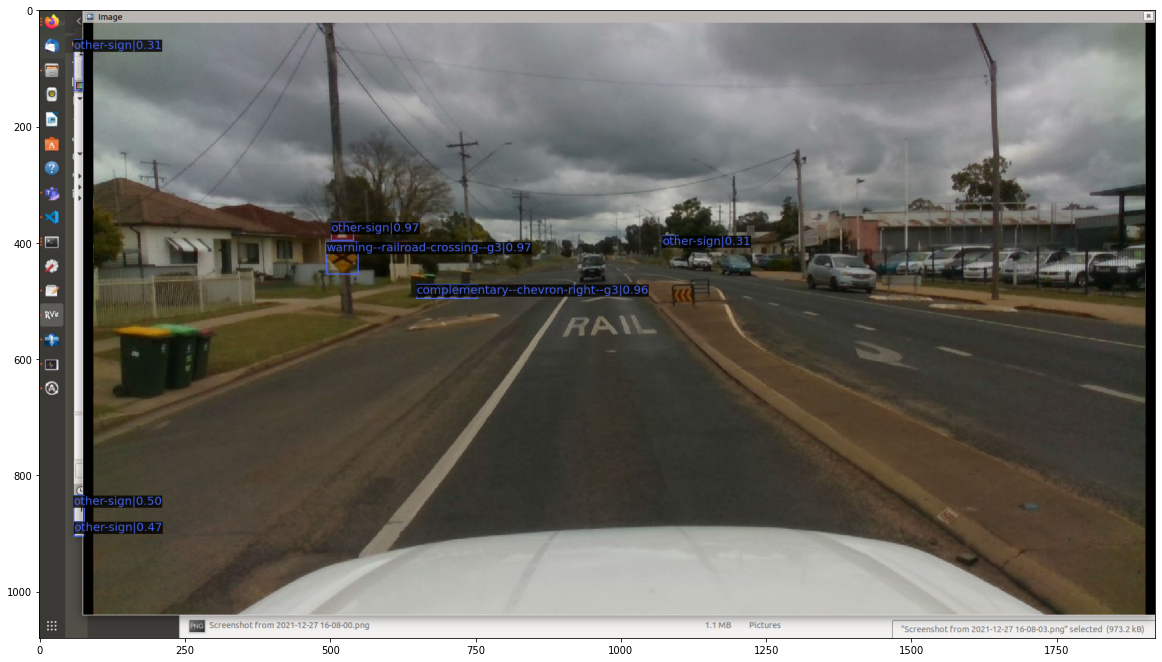

In [98]:
plt.figure(figsize=(20,20))
plt.imshow(viz_image)